### Задание со звездочкой 18. Кластеризация текстов

Мы сделали кластеризацию **слов** на основе их векторных представлений. На самом деле, кластеризовывать тексты гораздо сложнее и интереснее; для этой задачи существуют специальные модели, эти модели обучаются на **корпусе текстов**. Мы поговорим о таких моделях в следующем семестре, и быстро обобщим их до **тематического моделирования**, но это будет потом. А что делать, если датасета с текстами нет? Наивный подход состоит в том, чтобы как-нибудь аггрегировать векторные представления слов, например взять их среднее.

Ваша задача - предложите способ кластеризации **предложений**, который бы использовал только векторные представления слов, реализуйте и продемонстрируйте, что ваш способ работает лучше, чем наивный.

**Подсказка:** _того, что было рассказано сегодня, должно быть достаточно, нужно только грамотно скомпоновать разные части практики._

### Решение

Сравним два подхода

1. Наивный подход: Использует простое усреднение векторов слов для получения вектора предложения.2. 
Взвешенный подход: Использует TF-IDF для взвешивания векторов слов перед их агрегацией

In [1]:
import warnings
import numpy as np
import re
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

np.random.seed(2025)  
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.feature_extraction.text')

In [2]:
with open('/kaggle/input/fallout-possible-items-txt/fallout_possible_items.txt', 'r', encoding='utf-8') as f:
    sentences = [line.strip() for line in f.readlines()]

def clean_word(word):
    return re.sub(r'\W+', '', word).lower() 

unique_words = set(clean_word(word) for word in " ".join(sentences).split())
word_vectors = {word: np.random.rand(3) for word in unique_words}  

def naive_aggregate_sentence_vector(sentence):
    words = [clean_word(word) for word in sentence.split()] 
    vectors = [word_vectors[word] for word in words if word in word_vectors]
    return np.mean(vectors, axis=0)

def weighted_aggregate_sentence_vector(sentence, tfidf):
    words = [clean_word(word) for word in sentence.split()]  
    vectors = [word_vectors[word] * tfidf[word] for word in words if word in word_vectors]
    return np.sum(vectors, axis=0)

vectorizer = TfidfVectorizer(tokenizer=lambda x: [clean_word(word) for word in x.split()])
tfidf_matrix = vectorizer.fit_transform(sentences)
tfidf = dict(zip(vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))

naive_sentence_vectors = np.array([naive_aggregate_sentence_vector(sentence) for sentence in sentences])

weighted_sentence_vectors = np.array([weighted_aggregate_sentence_vector(sentence, tfidf) for sentence in sentences])

naive_clustering = AgglomerativeClustering(n_clusters=2)
naive_labels = naive_clustering.fit_predict(naive_sentence_vectors)

weighted_clustering = AgglomerativeClustering(n_clusters=2)
weighted_labels = weighted_clustering.fit_predict(weighted_sentence_vectors)

naive_linkage_matrix = linkage(naive_sentence_vectors, method='ward')

weighted_linkage_matrix = linkage(weighted_sentence_vectors, method='ward')

Силуэтный коэффициент (наивный подход): 0.265
Силуэтный коэффициент (взвешенный подход): 0.647


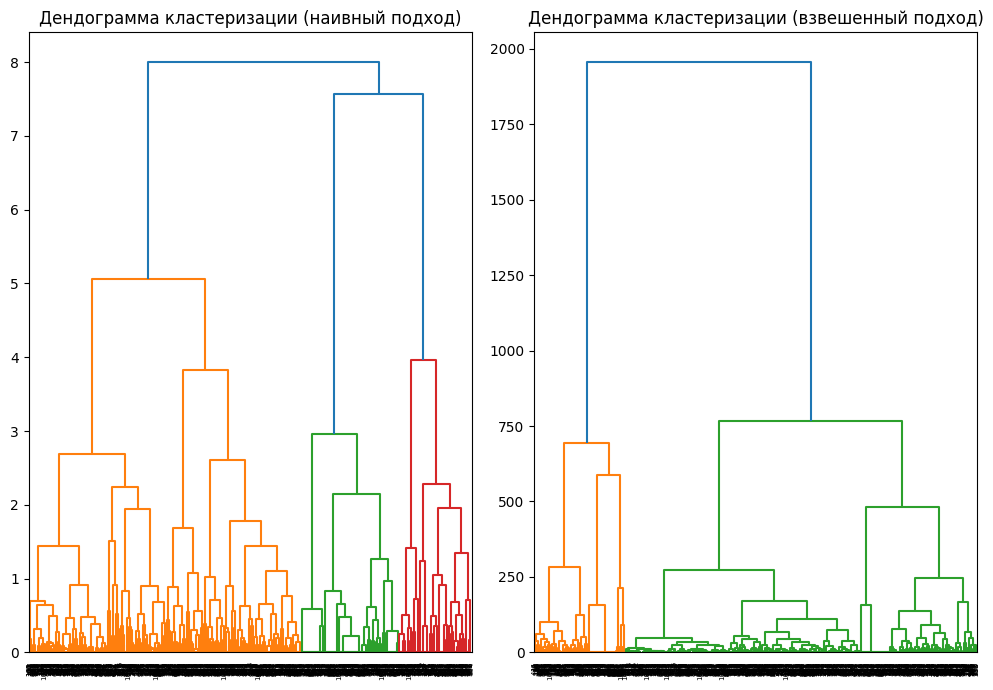

In [3]:
naive_silhouette = silhouette_score(naive_sentence_vectors, naive_labels)
print(f"Силуэтный коэффициент (наивный подход): {naive_silhouette:.3f}")

weighted_silhouette = silhouette_score(weighted_sentence_vectors, weighted_labels)
print(f"Силуэтный коэффициент (взвешенный подход): {weighted_silhouette:.3f}")

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
dendrogram(naive_linkage_matrix)
plt.title("Дендограмма кластеризации (наивный подход)")

plt.subplot(1, 2, 2)
dendrogram(weighted_linkage_matrix)
plt.title("Дендограмма кластеризации (взвешенный подход)")

plt.tight_layout()
plt.show()

### Вывод
Метрика взвешенного подхода лучше? Лучше! Значит и метод лучше)